In [1]:
import pandas as pd
import re,string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Value Similarity

In [2]:
df_google = pd.read_csv('Scraper/google1.csv', encoding= "iso-8859-1")
df_dell = pd.read_csv('Scraper/Dell_csv.csv', encoding= "iso-8859-1")
df_apple = pd.read_csv('Scraper/apples_reviews.csv', encoding= "iso-8859-1")
df_schwab = pd.read_csv('Scraper/charles.csv', encoding= "iso-8859-1")
df_amazon = pd.read_csv('Scraper/amazon.csv', encoding= "iso-8859-1")

In [7]:
df_ibm = pd.read_csv("ibm.csv")

https://www.linkedin.com/pulse/brilliant-examples-company-values-amazon-google-microsoft-j-d-meier/

In [3]:
core_values_google = """1) We want to work with great people
We hire great people and expect a lot from them
We create an environment where people can flourish and grow
We treat people with fairness and respect
We challenge each other’s ideas openly
We value diversity in people and ideas
We are a quantitative company that uses data to make decisions

2) Technology innovation is our lifeblood
Build the world’s best technology and products
We apply technology and creativity to solve important problems

3) Working at Google is fun
We expect our people to know and enjoy each other
We have a challenging/energetic work environment
We celebrate our successes and each other’s accomplishments – both professional and personal

4) Be actively involved; you are Google
Honor commitments
We openly communicate and trust you with a great deal of information and we expect you to honor our confidentiality
Understand when you are representing Google and act appropriately

5) take success for granted
Think and act like an underdog
Be humble with success; be arrogant
Be scrappy and resourceful

6) Do the right thing;be evil
Honesty and integrity in all we do
Our business practices are beyond reproach
We make money by doing good things

7) Earn customer and user loyalty and respect every day
Create, enhance and maintain great products and services

8) Sustainable long-term growth and profitability are key to our success
Think scale and efficiency
Every dollar is yours
Do things that matter

9) Google cares about and supports the communities where we work and live
We encourage and enable our people to support local community involvement and expect them to participate

10) We aspire to improve and change the world
Aim high; think BIG, take risks"""

In [4]:
core_values_amazon = """Customer Obsession. Leaders start with the customer and work backwards. They work vigorously to earn and keep customer trust. Although leaders pay attention to competitors, they obsess over customers. Ownership
Leaders are owners. They think long term and don’t sacrifice long-term value for short-term results. They act on behalf of the entire company, beyond just their own team. They never say that’s not my job. 

Invent and Simplify
Leaders expect and require innovation and invention from their teams and always find ways to simplify. They are externally aware, look for new ideas from everywhere, and are not limited by “not invented here". As we do new things, we accept that we may be misunderstood for long periods of time.

Are Right, A Lot
Leaders are right a lot. They have strong judgment and good instincts. They seek diverse perspectives and work to disconfirm their beliefs.

Learn and Be Curious
Leaders are never done learning and always seek to improve themselves. They are curious about new possibilities and act to explore them.

Hire and Develop the Best
Leaders raise the performance bar with every hire and promotion. They recognize exceptional talent, and willingly move them throughout the organization. Leaders develop leaders and take seriously their role in coaching others. We work on behalf of our people to invent mechanisms for development like Career Choice.

Insist on the Highest Standards
Leaders have relentlessly high standards - many people may think these standards are unreasonably high. Leaders are continually raising the bar and drive their teams to deliver high quality products, services and processes. Leaders ensure that defects do not get sent down the line and that problems are fixed so they stay fixed.

Think Big
Thinking small is a self-fulfilling prophecy. Leaders create and communicate a bold direction that inspires results. They think differently and look around corners for ways to serve customers.

Bias for Action
Speed matters in business. Many decisions and actions are reversible and do not need extensive study. We value calculated risk taking. 

Frugality
Accomplish more with less. Constraints breed resourcefulness, self-sufficiency and invention. There are no extra points for growing headcount, budget size or fixed expense.

Earn Trust
Leaders listen attentively, speak candidly, and treat others respectfully. They are vocally self-critical, even when doing so is awkward or embarrassing. Leaders do not believe their or their team’s body odor smells of perfume. They benchmark themselves and their teams against the best.

Dive Deep
Leaders operate at all levels, stay connected to the details, audit frequently, and are skeptical when metrics and anecdote differ. No task is beneath them.

Have Backbone; Disagree and Commit
Leaders are obligated to respectfully challenge decisions when they disagree, even when doing so is uncomfortable or exhausting. Leaders have conviction and are tenacious. They do not compromise for the sake of social cohesion. Once a decision is determined, they commit wholly.

Deliver Results
Leaders focus on the key inputs for their business and deliver them with the right quality and in a timely fashion. Despite setbacks, they rise to the occasion and never settle."""

In [5]:
core_values_apple = """We believe that we’re on the face of the Earth to make great products.

We believe in the simple, not the complex.

We believe that we need to own and control the primary technologies behind the products we make.

We participate only in markets where we can make a significant contribution.

We believe in saying no to thousands of projects so that we can really focus on the few that are truly important and meaningful to us.

We believe in deep collaboration and cross-pollination of our groups, which allow us to innovate in a way that others cannot.

We don’t settle for anything less than excellence in every group in the company, and we have the self-honesty to admit when we’re wrong and the courage to change.
"""

In [6]:
core_values_schwab = """
Our purpose is to champion every client’s goals with passion and integrity. This purpose drives us to help our clients take ownership of their financial futures, helping people at all levels of income and every stage of life, because investing for the future is one of the most important things people can do for themselves and their families. We believe it is critical to the health of our communities and to our society.

Earning our clients’ trust by treating clients in an ethical, empathetic and proactive way

Constantly improving the client experience through innovation that benefits clients

Respecting fellow employees and reinforcing the power of teamwork

Being good stewards of our brand and stockholder value"""

In [7]:
core_values_dell = """
Customers: We believe our relationships with customers are the ultimate differentiator and the foundation for our success.

Winning Together: We believe in and value our people. We perform better, are smarter, and have more fun working as a team than as individuals.

Innovation: We believe our ability to innovate and cultivate breakthrough thinking is an engine for growth, success and progress. 

Results: We believe in holding ourselves accountable to a higher standard of excellence and performance. 

Integrity: We believe integrity must always govern our fierce desire to win."""

In [10]:
core_values_ibm = """
passionate about building strong, long-lasting client relationships. This dedication spurs us to go "above and beyond" on our client's behalf.

focused on outcomes. We sell products, services and solutions to help our clients succeed, however they measure success.

demonstrate this personal dedication to every client, from the largest corporation and government agency to the smallest organization.

no matter where they work, have a role in client success. It requires the full spectrum of IBM expertise.
"""

In [8]:
# Cosine Similarity
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

def cosine_pros_cons(df,value_list):
    df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons',
       'advice_to_management']

    df.pros = df.pros.astype(str)
    df.cons = df.cons.astype(str)
    
    pros = df.pros.sum()
    cons = df.cons.sum()

    for value in value_list:
        print(value)
        print("Similarity with pros:",cosine_sim(pros,value))
        print("Similarity with cons:",cosine_sim(cons,value))

In [11]:
cosine_pros_cons(df_ibm,core_values_ibm.split('\n\n'))


passionate about building strong, long-lasting client relationships. This dedication spurs us to go "above and beyond" on our client's behalf.
('Similarity with pros:', 0.03144398783419432)
('Similarity with cons:', 0.039976613917652476)
focused on outcomes. We sell products, services and solutions to help our clients succeed, however they measure success.
('Similarity with pros:', 0.03560276124310735)
('Similarity with cons:', 0.04592603653419965)
demonstrate this personal dedication to every client, from the largest corporation and government agency to the smallest organization.
('Similarity with pros:', 0.03078643677384109)
('Similarity with cons:', 0.06623133825532596)
no matter where they work, have a role in client success. It requires the full spectrum of IBM expertise.

('Similarity with pros:', 0.23464355435483794)
('Similarity with cons:', 0.1686043111343401)


In [9]:
cosine_pros_cons(df_google,core_values_google.split('\n\n'))

1) We want to work with great people
We hire great people and expect a lot from them
We create an environment where people can flourish and grow
We treat people with fairness and respect
We challenge each other’s ideas openly
We value diversity in people and ideas
We are a quantitative company that uses data to make decisions
Similarity with pros: 0.4019688164004321
Similarity with cons: 0.27296751357607596
2) Technology innovation is our lifeblood
Build the world’s best technology and products
We apply technology and creativity to solve important problems
Similarity with pros: 0.04724143595585088
Similarity with cons: 0.030817870202272796
3) Working at Google is fun
We expect our people to know and enjoy each other
We have a challenging/energetic work environment
We celebrate our successes and each other’s accomplishments – both professional and personal
Similarity with pros: 0.3119861051110692
Similarity with cons: 0.23277709302644578
4) Be actively involved; you are Google
Honor com

In [10]:
cosine_pros_cons(df_apple,core_values_apple.split('\n\n'))

We believe that we’re on the face of the Earth to make great products.
Similarity with pros: 0.15939683251342252
Similarity with cons: 0.0575408449103961
We believe in the simple, not the complex.
Similarity with pros: 0.0034424155532958058
Similarity with cons: 0.004088967552778628
We believe that we need to own and control the primary technologies behind the products we make.
Similarity with pros: 0.0726292173133259
Similarity with cons: 0.06392531503995107
We participate only in markets where we can make a significant contribution.
Similarity with pros: 0.02462858483130385
Similarity with cons: 0.04998029719138241
We believe in saying no to thousands of projects so that we can really focus on the few that are truly important and meaningful to us.
Similarity with pros: 0.03206560123062152
Similarity with cons: 0.03944997212410613
We believe in deep collaboration and cross-pollination of our groups, which allow us to innovate in a way that others cannot.
Similarity with pros: 0.017436

In [11]:
cosine_pros_cons(df_schwab,core_values_schwab.split('\n\n'))


Our purpose is to champion every client’s goals with passion and integrity. This purpose drives us to help our clients take ownership of their financial futures, helping people at all levels of income and every stage of life, because investing for the future is one of the most important things people can do for themselves and their families. We believe it is critical to the health of our communities and to our society.
Similarity with pros: 0.14212364974267794
Similarity with cons: 0.10557842442138379
Earning our clients’ trust by treating clients in an ethical, empathetic and proactive way
Similarity with pros: 0.0723462848299941
Similarity with cons: 0.04695927087648214
Constantly improving the client experience through innovation that benefits clients
Similarity with pros: 0.1376156527650185
Similarity with cons: 0.07331830520718687
Respecting fellow employees and reinforcing the power of teamwork
Similarity with pros: 0.04737999028287742
Similarity with cons: 0.05990397212235991
B

In [12]:
cosine_pros_cons(df_dell,core_values_dell.split('\n\n'))


Customers: We believe our relationships with customers are the ultimate differentiator and the foundation for our success.
Similarity with pros: 0.018509489580300936
Similarity with cons: 0.029393758327492095
Winning Together: We believe in and value our people. We perform better, are smarter, and have more fun working as a team than as individuals.
Similarity with pros: 0.2282635377448779
Similarity with cons: 0.1592595614709928
Innovation: We believe our ability to innovate and cultivate breakthrough thinking is an engine for growth, success and progress. 
Similarity with pros: 0.019705148658344815
Similarity with cons: 0.047025564304502825
Results: We believe in holding ourselves accountable to a higher standard of excellence and performance. 
Similarity with pros: 0.01470152033407545
Similarity with cons: 0.032599022576867726
Integrity: We believe integrity must always govern our fierce desire to win.
Similarity with pros: 0.008456599327941525
Similarity with cons: 0.0193987429427

In [13]:
cosine_pros_cons(df_amazon,core_values_amazon.split('\n\n'))

Customer Obsession. Leaders start with the customer and work backwards. They work vigorously to earn and keep customer trust. Although leaders pay attention to competitors, they obsess over customers. Ownership
Leaders are owners. They think long term and don’t sacrifice long-term value for short-term results. They act on behalf of the entire company, beyond just their own team. They never say that’s not my job. 
Similarity with pros: 0.2206572815781876
Similarity with cons: 0.19770839142208177
Invent and Simplify
Leaders expect and require innovation and invention from their teams and always find ways to simplify. They are externally aware, look for new ideas from everywhere, and are not limited by “not invented here". As we do new things, we accept that we may be misunderstood for long periods of time.
Similarity with pros: 0.06819217588651742
Similarity with cons: 0.09445455504693852
Are Right, A Lot
Leaders are right a lot. They have strong judgment and good instincts. They seek di

# Sentiment

In [6]:
fig_size = plt.rcParams["figure.figsize"]

#Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [12]:
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import copy
analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return(snt['compound'])

def get_pos_neg(sentence):
    snt = analyser.polarity_scores(sentence)
    if(snt['pos'] > snt['neg']):
        return('pos')
    return('neg')

def sentiment_analysis(dfx):
    df = copy.deepcopy(dfx)
    df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons',
       'advice_to_management']

    df.pros = df.pros.astype(str)
    df.cons = df.cons.astype(str)
    
    df['pc'] = df.pros + ' ' + df.cons
    
    df['sent_score'] = df.pc.map(get_sentiment_scores)
    df['pos_neg'] = df.pc.map(get_pos_neg)
    
    df['date'] = pd.to_datetime(df['date_written'],errors = 'coerce')
    df.set_index('date', inplace=True)
    df2 = df[['sent_score']].resample("M").mean()
    y_mean = np.repeat(df['sent_score'].mean() ,df2.shape[0])
    plot(df2.index,y_mean,label='Mean', linestyle='--',color = 'k')
    plot(df2.index,df2['sent_score'])
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):

        print("Average sentiment score:",df['sent_score'].mean())

        print(df.groupby('current_former')[['sent_score']].mean())
        print(df.groupby('outlook')[['sent_score']].mean())
        print(df.groupby('recommendation')[['sent_score']].mean())

        print(df.job_title.value_counts()[:20])
        top_designations = df.job_title.value_counts().index[:20]
        print(df[df.job_title.isin(top_designations)].groupby('job_title')['sent_score'].mean().nlargest(20))

        print(df.location.value_counts()[:10])
        top_locations = df.location.value_counts().index[:10]
        print(df[df.location.isin(top_locations)].groupby('location')['sent_score'].mean().nlargest(10))
        print(df[df.location.isin(top_locations) & df.job_title.isin(top_designations)].pivot_table(index='location', columns='job_title', values='sent_score',aggfunc='mean'))
        #print(df[df.location.isin(top_locations) & df.job_title.isin(top_designations) ].groupby(['location','job_title'])[['sent_score']].mean())

/Users/tiffanysung/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


('Average sentiment score:', 0.47186826999999965)
                  sent_score
current_former              
Current Employee    0.479886
Former Employee     0.462150
                  sent_score
outlook                     
Negative Outlook    0.365816
Neutral Outlook     0.497008
Positive Outlook    0.567006
                   sent_score
recommendation               
Doesn't Recommend    0.373636
Recommends           0.567475
Anonymous Employee            5054
Software Engineer              231
Senior Consultant              134
Project Manager                131
Consultant                     104
Managing Consultant             97
Senior Software Engineer        89
IT Specialist                   72
Advisory Software Engineer      68
Staff Software Engineer         66
Program Manager                 61
Senior Managing Consultant      59
Senior Project Manager          57
Manager                         54
Financial Analyst               54
Sales                           46
Software 

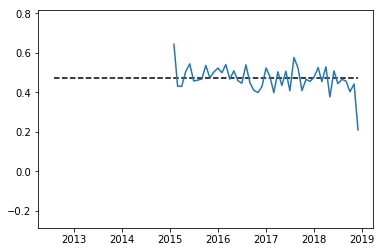

In [13]:
sentiment_analysis(df_ibm)

Average sentiment score: 0.594397791972242
                  sent_score
current_former              
Current Employee    0.602521
Former Employee     0.583964
                                              sent_score
outlook                                                 
- You will never have to use MS Outlook etc.   -0.420100
Negative Outlook                                0.403608
Neutral Outlook                                 0.558291
Positive Outlook                                0.632972
                                                    sent_score
recommendation                                                
Doesn't Recommend                                     0.440736
Recommend they host events (Parties) in other c...    0.743000
Recommends                                            0.641581
Anonymous Employee              4858
Specialist                      1035
Mac Specialist (Apple Store)     356
Family Room Specialist           297
Mac Genius                       235

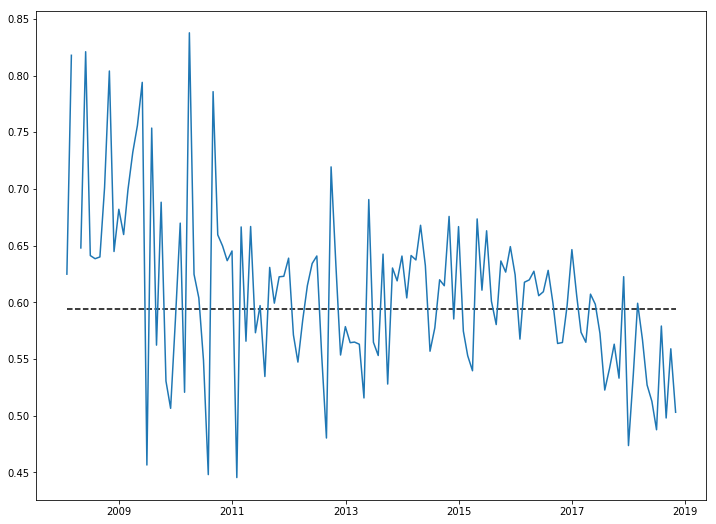

In [16]:
sentiment_analysis(df_apple)

Average sentiment score: 0.6068928328092242
                  sent_score
current_former              
Current Employee    0.604190
Former Employee     0.610926
                  sent_score
outlook                     
Negative Outlook    0.436774
Neutral Outlook     0.571005
Positive Outlook    0.628382
                   sent_score
recommendation               
Doesn't Recommend    0.442568
Recommends           0.634093
Anonymous Employee              3776
Software Engineer                636
Senior Software Engineer         192
Account Manager                   90
Product Manager                   90
Account Strategist                81
Software Engineer III             75
Program Manager                   74
Staff Software Engineer           58
Intern                            54
Product Marketing Manager         44
Analyst                           42
Account Executive                 36
Site Reliability Engineer         30
Sales Manager                     30
Software Developer  

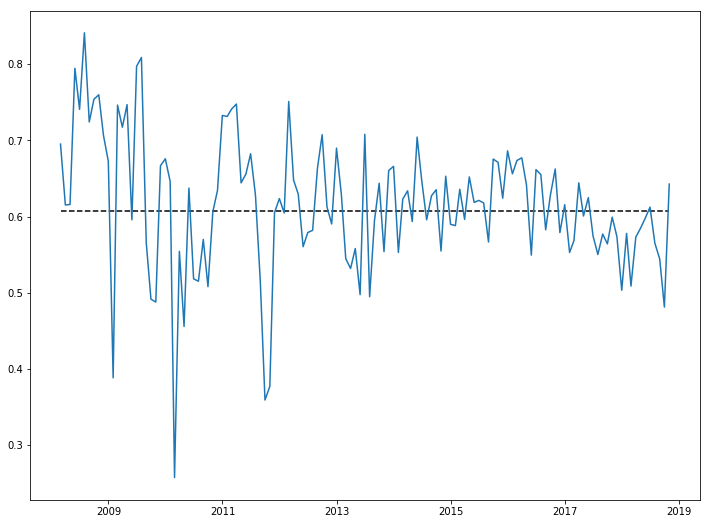

In [17]:
sentiment_analysis(df_google)

Average sentiment score: 0.48669658706112995
                  sent_score
current_former              
Current Employee    0.486078
Former Employee     0.487640
                  sent_score
outlook                     
Negative Outlook    0.342329
Neutral Outlook     0.485380
Positive Outlook    0.560669
                   sent_score
recommendation               
Doesn't Recommend     0.34608
Recommends            0.55416
Anonymous Employee                     4499
Software Engineer                       154
Inside Sales Representative             140
Account Executive                       136
Project Manager                         132
Senior Software Engineer                124
Director                                107
Account Manager                          93
Software Developer                       92
Senior Manager                           78
Program Manager                          78
Business Analyst                         75
Senior Analyst                           72
Se

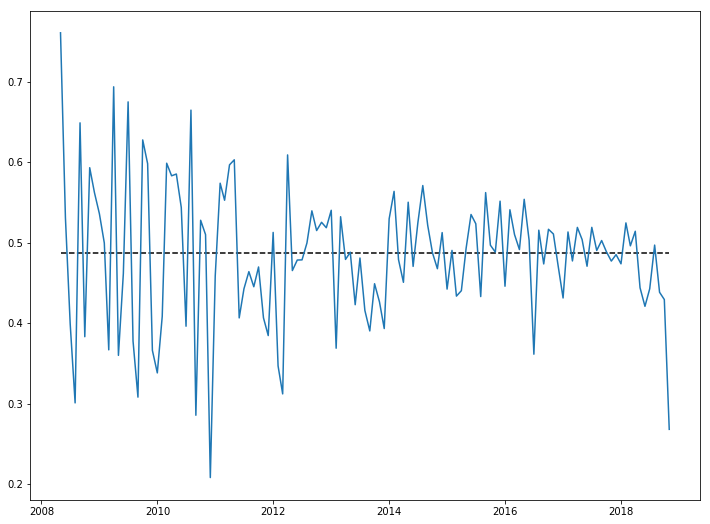

In [18]:
sentiment_analysis(df_dell)

Average sentiment score: 0.574031036192365
                  sent_score
current_former              
Current Employee    0.575052
Former Employee     0.572786
                  sent_score
outlook                     
Negative Outlook    0.397885
Neutral Outlook     0.554633
Positive Outlook    0.643346
                   sent_score
recommendation               
Doesn't Recommend    0.446871
Recommends           0.664434
Anonymous Employee                      824
Registered Representative                68
Senior Manager                           65
Financial Consultant                     41
Managing Director                        39
Manager                                  29
Director                                 28
Vice President, Financial Consultant     23
Client Service Specialist                21
Operations Specialist                    21
Customer Service Representative          20
Relationship Specialist                  18
Vice President                           17
Proj

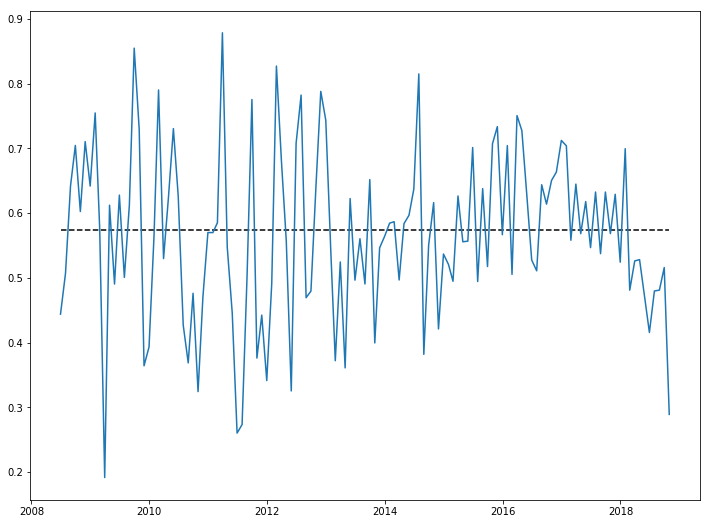

In [19]:
sentiment_analysis(df_schwab)

Average sentiment score: 0.4400635815772669
                  sent_score
current_former              
Current Employee    0.465844
Former Employee     0.388707
                  sent_score
outlook                     
Negative Outlook    0.166517
Neutral Outlook     0.363889
Positive Outlook    0.512031
                                    sent_score
recommendation                                
Doesn't Recommend                     0.255852
Recommend 5 day week 8 hours a day    0.000000
Recommends                            0.531468
Anonymous Employee                  9885
Warehouse Associate                  653
Fulfillment Associate                592
Software Development Engineer        573
Area Manager                         302
Software Development Engineer II     269
Customer Service Associate           246
Software Development Engineer I      225
Associate                            217
Software Engineer                    212
Picker                               202
Process A

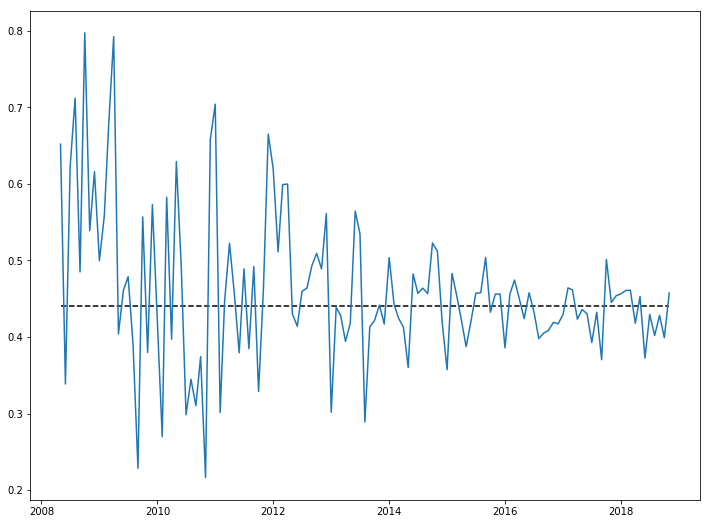

In [20]:
sentiment_analysis(df_amazon)